## Create the auxiliary environment, for which we can deploy an agent with his learning algorithm

 1. Random
 2. Greedy
 3. Epsilon-Greedy
 4. Optimistic Initial Values
 5. Upper-Confidence-Bound Action Selection (UCP)
 6. Gradient Bandit Algorithm
 
 There is a difference between action-selection algorithms, and state evaluation algorithms. We will just implement each algorithm independent of each other and see how the code evolves

First of all, we create this auxiliary k-bandit environment, where we have k different actions. Let's assume these are independent of each other and stationary. We create k different expectation values, which our agent will try to approximate with time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

Here, we create k 'bandits, having a different mean value

In [2]:
#Create k bandits, each havin g the same distribution

k = 10

num_samples = 100
mu = [100]
while np.abs(np.sum(mu)) > 0.01:
    mu = [np.sum(batch) / num_samples for batch in np.split(np.random.normal(0, 100, k*num_samples), k)]
#print mu.shape
print("The {:d} different means are: ".format(k))
for mean in mu:
    print "\t{:.5}".format(mean)
print("The total mean (mean of means) is {:.5f}, which is an ok approximation, lying close enough to 0".format(np.sum(mu)/k))


The 10 different means are: 
	-4.1997
	-13.807
	-3.7405
	4.3576
	-1.2969
	2.7959
	8.5664
	10.352
	-7.9193
	4.886
The total mean (mean of means) is -0.00052, which is an ok approximation, lying close enough to 0


Then we create a normal distribution around those mean values. This is solely for the purpose of having data points, such that we can graph them in bars, as done by Sutton and Burto (see Fig. 2.1). I am not entirely sure why mine is not as smooth. I assume it is because they have actually assumed it to be a random distrubution instead of generating 'num_samples' points, and then plotting them. (Yes, this actually makes sense, but this is easier for me :) )

In [3]:
#create auxiliary data around for each mean
bandits = np.zeros((num_samples, len(mu)))
for r in range(len(mu)):
    bandits[:, r] = np.random.normal(mu[r], 1, num_samples)
    
print bandits.shape
    

(100, 10)


Now finally we can display the auxiary created data through nice violin-plots. There are k different distributions, representing the k different 'bandits' (expectancy values)

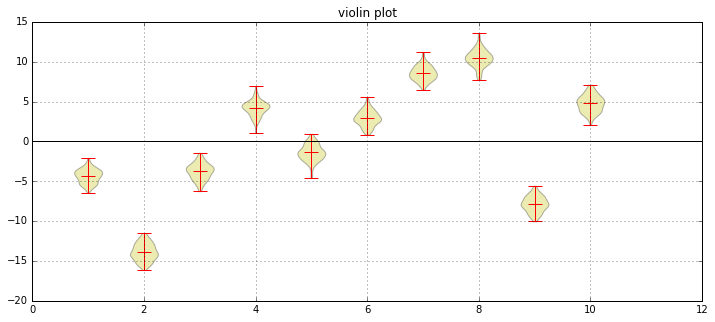

In [4]:
#display means
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

axes.violinplot(bandits, showmeans=True,)
axes.set_title('violin plot')
axes.grid(True, which='both')
axes.axhline(y=0, color='k')
axes.axvline(x=0, color='k')

plt.show()


## Create the agent, including the learning algorithm to approximate the expectation value for each of these bandits

Now that we have created this 'testbed', as they call it in the book, we can write algorithms that approximate the expectation value for each of these bandits. Here, they have some initial guess, and iteratively, better approximate the true mean. In the real world, we wouldn't really know the how the environment would look like. In this case we do know this, as we had to program (a static) environment, for which we can run the algorithms

We first define a function 'step', which takes as input the algorithm whose performance we want to measure.
We measure the performance with two quantities:
 1. Average reward: This is simply how much reward we get by choosing an action. Simple.
 2. % of Optimal Actions: We have a stationary environment. As such, we have one bandit which always gives us the best (mean) reward. We want to make sure that our algorithm finds out which bandit this is, and takes this bandit as it's action

In [5]:
#Current expectancy values
#def step(E, bandits, policy_fnc, update_fnc, policy_fnc_args = None, update_fnc_args = None):
#    action = policy_fnc(E, *policy_fnc_args) #where 0 <= action <= len(E), if E is one-dimensional
#    reward = bandits[action] #the real valued function received from the bandit
#    E = update_fnc(E, action, reward, alpha=0.15) #assume this is ok
#    return E, action, reward
#Function are too different, I think this 'step' approach is then not the best anymore...

We must define default functions in case we don't want anything fancy.
The default update function is the simple:

  * Default: _Q<sub>(n+1)</sub> = Q<sub>(n)</sub> + &alpha; $\cdot$ ( R<sub>(n)</sub> - Q<sub>(n)</sub>)_
  
 > Where &alpha; is a hyperparameter, the step size, <br />
 > R<sub>(n)</sub> is the reward received at time step n, and <br />
 > Q<sub>(n)</sub> is the expectation of the bandit's mean value at time n
 
 The choice functions include:
 
  * Random: Chose an action with probability $ \frac{1}{ k } $
  
  > Where _k_ is the number of different bandits
  
  * Greedy: _A<sub>t</sub> = argmax<sub>a</sub>(E[a])_
  >  Where _E[a]_ is the expected reward if action a is chosen
  
  * Eps-Greedy: $ \begin{cases} 
      random & p\ge \epsilon \\
       greedy & p\leq \epsilon 
   \end{cases}
 $
  > where $ \epsilon $ is the exploration-rate
  
  * Optimistic Initial Values: Greedy, but where the inital expectancy values are positive
  > So the inital condition is E = E + positive_offset
  
  * Upper-Confidence-Bound Action Selection (UCP): $ A_{t} = argmax_{a} ( Q_{t} + c \cdot \sqrt{ \frac{\log t}{N_{t}(a)}}  ) $ 
  >  Where c is a hyperparameter, <br />
  > ${N_{t}(a)}$ is the number of times action a has been selected prior to time t
  
  * Gradient Bandit Algorithm: 
  >
  >
  

In [6]:
#Update rules
def update_default(E, action, reward, alpha):
    E[action] = E[action] + alpha * (reward - E[action])
    return E
    
#Actions
def rand(E):
    action = np.random.choice([i for i in range(len(E))])
    return action
    
def greedy(E):
    return np.argmax(E)

def eps_greedy(E, eps):
    best = np.argsort(E)
    rnd = np.random.uniform()
    if ( rnd > eps ):
        #print best
        #print E
        return best[-1] #best action, if not exploring
    else:
        explore = np.random.choice(best[:-1]) #don't take greedy action (from what I've understood)
        return explore
    
#def optimistic_inital_values() depends on the initial setting of the expectations, nothing special about the algorithm
#However, I do not understand why then it would necessarily create the 'spike' at the beginning

def ucp(E, times_taken, c):
    confidence = E + c * np.sqrt(np.log(np.sum(times_taken)) / times_taken) #should not result problems bcs it's vectors...
    action = greedy(confidence)
    return action   


Finally, running and plotting individual curves

In [7]:
NUM_RUNS = 1000

#rand
#determine alpha aswell
def run_rand(alpha):
    E = np.zeros((k))
    actions = []
    rewards = []
    i = 1
    for _ in range(NUM_RUNS): #we choose 1000 because Sutton and Barto do so as well
        action = rand(E)
        reward = np.random.choice(bandits[action]) #bcs the dataset 'bandits' still have size 100, 10 (so 100 values for every bandit)
        E = update_default(E, action, reward, 1/float(i))
        
        actions.append(action)
        rewards.append(reward)
        
        i += 1
        
    return np.asarray(actions), np.cumsum(rewards)

#greedy
def run_greedy(alpha, optimistic=0):
    E = np.full((k), optimistic)
    actions = []
    rewards = []
    i = 1
    for _ in range(NUM_RUNS):
        action = greedy(E)
        reward = np.random.choice(bandits[action])
        E = update_default(E, action, reward, 1/float(i))
        
        actions.append(action)
        rewards.append(reward)
        
        i += 1
    
    return np.asarray(actions), np.cumsum(rewards)
        
#eps_greedy
def run_eps_greedy(alpha, eps):
    E = np.zeros((k))
    actions = []
    rewards = []
    i = 1
    for _ in range(NUM_RUNS):
        action = eps_greedy(E, eps)
        reward = np.random.choice(bandits[action])
        E = update_default(E, action, reward, 1/float(i))
        
        actions.append(action)
        rewards.append(reward)
        
        i += 1
    
    return np.asarray(actions), np.cumsum(rewards)

#ucp
def run_ucp(alpha, c):
    E = np.zeros((k))
    T = np.full((k), 1) #one-to-one relationship to how often each reward was respectively taken
    actions = []
    rewards = []
    i = 1
    for _ in range(NUM_RUNS):
        action = ucp(E, T, c)
        reward = np.random.choice(bandits[action])
        E = update_default(E, action, reward, 1/float(i))
        
        actions.append(action)
        rewards.append(reward)
        
        i += 1
        
    return np.asarray(actions), np.cumsum(rewards)

In [9]:
a = 0.125
eps = 0.2
c = 0.2

rand_actions, rand_reward = run_rand(a)
greed_actions, greed_reward = run_greedy(a)
eps_actions, eps_reward = run_eps_greedy(a, eps)
ucp_actions, ucp_reward = run_ucp(a, c)

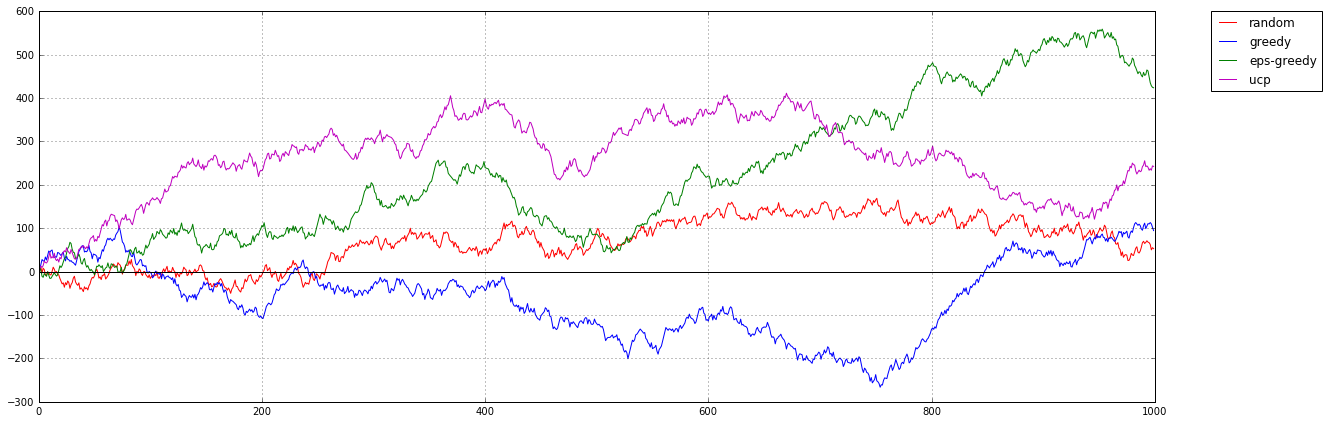

In [10]:
#Showing how often the optimal bandit has been selected
#opt_action = np.argmax(mu)
t = np.arange(0, NUM_RUNS, 1)

# red dashes, blue squares and green triangles
#plt.plot(t, rand_reward, 'r', t, greed_reward, 'b', t, eps_actions, 'g', t, ucp_reward, 'c')

plt.figure(figsize=(20, 7))
plt.plot(t, rand_reward, 'r', label="random")
plt.plot(t, greed_reward, 'b', label="greedy")
plt.plot(t, eps_reward, 'g', label="eps-greedy")
plt.plot(t, ucp_reward, 'm', label="ucp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, which='both')
#ax.set_aspect('equal')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

[0.081635206909923458, -0.16317133563291975, -0.082932428857663887, 0.065063519604290507, -0.14413806736593066, -0.07754844259810395, -0.031343991940296911, 0.1496941113750215, 0.070568186385866316, -0.1146007015914304]
7


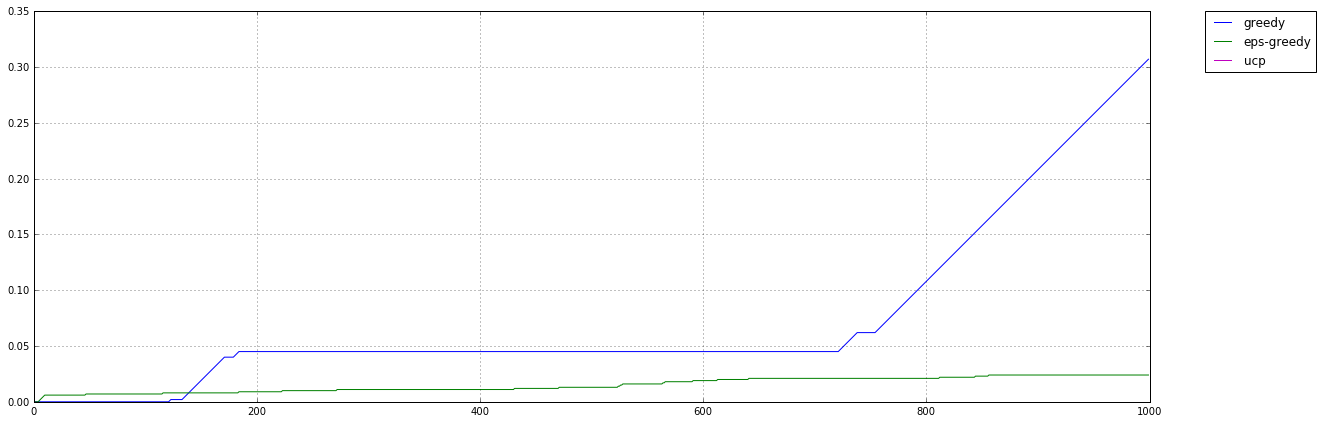

In [11]:
#Showing how often the optimal bandit has been selected
#opt_action = np.argmax(mu)
t = np.arange(0, NUM_RUNS, 1)

# red dashes, blue squares and green triangles
#plt.plot(t, rand_reward, 'r', t, greed_reward, 'b', t, eps_actions, 'g', t, ucp_reward, 'c')

print [np.sum(batch)/num_samples for batch in np.split(bandits, k)]
print np.argmax([np.sum(batch)/num_samples for batch in np.split(bandits.T, k)])
optimal_val = np.argmax([np.sum(batch)/num_samples for batch in np.split(bandits.T, k)])

rand_ones = rand_actions == optimal_val
rand_cs = np.cumsum(rand_ones) / float(len(rand_actions))
greed_ones = greed_actions == optimal_val
greed_cs = np.cumsum(greed_ones) / float(len(greed_actions))
eps_ones = eps_actions == optimal_val
eps_cs = np.cumsum(eps_ones) / float(len(eps_actions))
ucp_ones = ucp_actions == optimal_val
ucp_cs = np.cumsum(ucp_ones) / float(len(ucp_actions))

plt.figure(figsize=(20, 7))
#plt.plot(t, rand_cs, 'r', label="random")
plt.plot(t, greed_cs, 'b', label="greedy")
plt.plot(t, eps_cs, 'g', label="eps-greedy")
plt.plot(t, ucp_cs, 'm', label="ucp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, which='both')
#ax.set_aspect('equal')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

Now, as these are only random samplings, we must create the average over e runs

In [41]:
a = 0.125
eps = 0.2
c = 0.2    
EPOCHS = 10000 #number of epochs
t = np.arange(0, NUM_RUNS, 1)

#we add up to these variables to later on plot an average
rand_actions, rand_reward = run_rand(a)
greed_actions, greed_reward = run_greedy(a)
eps_actions, eps_reward = run_eps_greedy(a, eps)
ucp_actions, ucp_reward = run_ucp(a, c)

#this should give us a good approximation by the law of large numbers
for e in range(EPOCHS):
    #run sampling experiments
    a_rand, r_rand = run_rand(a)
    a_greed, r_greed = run_greedy(a)
    a_eps, r_eps = run_eps_greedy(a, eps)
    a_ucp, r_ucp = run_ucp(a, c)
    
    #average over 
    rand_actions += a_rand / (e+1) #should be elemt-wise sum, hope python lists support this
    greed_actions += a_greed / (e+1)
    eps_actions += a_eps / (e+1)
    ucp_actions += a_ucp / (e+1)
    
    rand_reward += r_rand / (e+1) #should be elemt-wise sum, hope python lists support this
    greed_reward += r_greed / (e+1)
    eps_reward += r_eps / (e+1)
    ucp_reward += r_ucp / (e+1)
    
    
    if (e % (EPOCHS / 10) )== 0:
        print "At {:.2f} percent".format(float(e)/EPOCHS * 100)
    

#plot
optimal_val = np.argmax([np.sum(batch)/num_samples for batch in np.split(bandits.T, k)])

rand_ones = np.abs(rand_actions - optimal_val) < 0.5
rand_cs = np.cumsum(rand_ones) / float(len(rand_actions))
greed_ones = np.abs(greed_actions - optimal_val) < 0.5
greed_cs = np.cumsum(greed_ones) / float(len(greed_actions))
eps_ones = np.abs(eps_actions - optimal_val) < 0.5
eps_cs = np.cumsum(eps_ones) / float(len(eps_actions))
ucp_ones = np.abs(ucp_actions - optimal_val) < 0.5
ucp_cs = np.cumsum(ucp_ones) / float(len(ucp_actions))




At 0.00 percent
At 10.00 percent
At 20.00 percent
At 30.00 percent
At 40.00 percent
At 50.00 percent
At 60.00 percent
At 70.00 percent
At 80.00 percent
At 90.00 percent


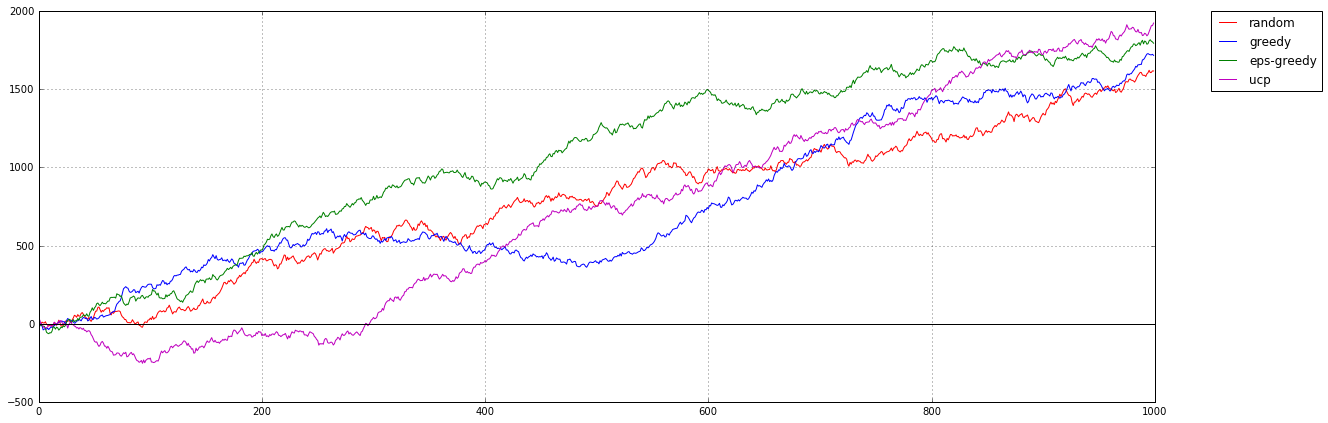

In [42]:
plt.figure(figsize=(20, 7))
plt.plot(t, rand_reward, 'r', label="random")
plt.plot(t, greed_reward, 'b', label="greedy")
plt.plot(t, eps_reward, 'g', label="eps-greedy")
plt.plot(t, ucp_reward, 'm', label="ucp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

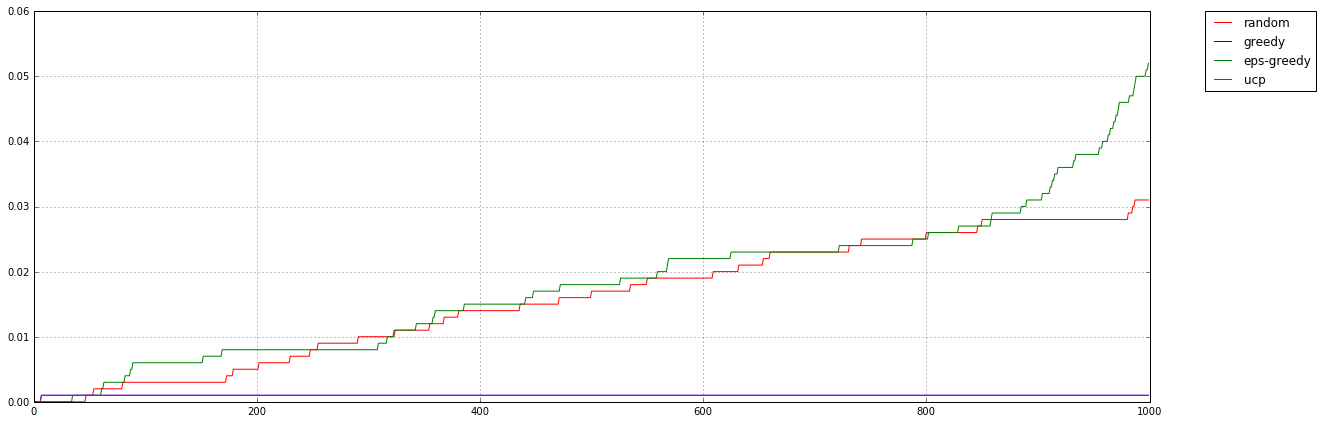

In [43]:
plt.figure(figsize=(20, 7))
plt.plot(t, rand_cs, 'r', label="random")
plt.plot(t, greed_cs, 'b', label="greedy")
plt.plot(t, eps_cs, 'g', label="eps-greedy")
plt.plot(t, ucp_cs, 'm', label="ucp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

The very last figures still don't fully make sense. Maybe the optimal action was not the optimal action afterall? Also, the reward graphs fluctuate quite a lot. Maybe I had an error in the design or code? You certainly wouldn't expect that when reading Sutton and Barto's book...
Also, I thought that I could use the random policy as a baseline, and expected that all agents would perform better than this. Doesn't seem to be the case!

In [ ]:
Todo:
    1. 